In [86]:
import pickle
from tqdm import tqdm
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from loaders import DataLoader
from strategies.arima import StrategyARIMA, StrategyARIMAGARCH
from strategies import BaseStrategy

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = DataLoader.load('ibm', sampling='3H', year_start=2000)

# Intro

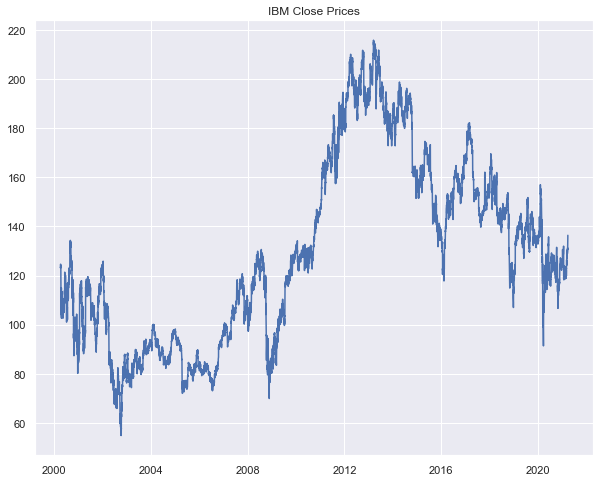

In [110]:
plt.figure(figsize=(10, 8))
plt.plot(df['Date'], df['Close'])
plt.title('IBM Close Prices')
# plt.grid()
# plt.savefig('IBM_spot.jpg')
plt.show()

Quite a few linear models assume the stationarity in time series as they account for oscillations but not for trends. Usually raw financial time series are non-stationary. Let's test that using Dickey-Fuller test for stationarity.

In [111]:
temp_df = []
for year in df['Date'].dt.year.unique()[::3]:
    res = adfuller(df[df['Date'].dt.year == year]['Close'].values)
    temp_df.append({'year': year, 'p-value': round(res[1], 4)})
pd.DataFrame(temp_df)

,year,p-value
0,2000,0.6436
1,2003,0.3632
2,2006,0.9883
3,2009,0.7422
4,2012,0.0687
5,2015,0.8666
6,2018,0.8959
7,2021,0.7081


As we can see for each year p-value is above the significance level, therefore our time series are non-statinory. One of the most common ways is to take logarithmic returns of our time series which will convert the original price series from a non-stationary series to a potentially stationary one.

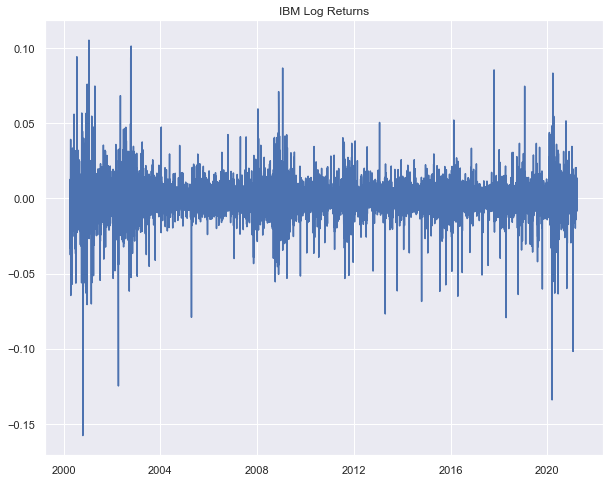

In [112]:
plt.figure(figsize=(10, 8))
plt.plot(df['Date'], df['ln_Close'])
plt.title('IBM Log Returns')
plt.savefig('IBM_spot_log.jpg')
plt.show()

To make sure let's rerun Dickey-Fuller test to see that p-values are less than the significance level now.

In [115]:
temp_df = []
for year in df['Date'].dt.year.unique()[::3]:
    res = adfuller(df[df['Date'].dt.year == year]['ln_Close'].values)
    temp_df.append({'year': year, 'p-value': res[1]})
pd.DataFrame(temp_df)

,year,p-value
0,2000,2.819851e-28
1,2003,0.000000e+00
2,2006,0.000000e+00
3,2009,2.294270e-22
4,2012,1.678202e-22
5,2015,8.873117e-25
6,2018,0.000000e+00
7,2021,1.996048e-23


Since we are going to use ARIMA as our baseline model we'll need to estimate parameters `p` and `q` which are auto-regressions and moving average parameters respectively. We don't need to estimate integration parameter `d` as we've already taken care of it by taking log returns.

To get an idea of range of values that `p` and `q` can take let's plot the following correlograms which are simply the plots of the autocorrelation function for sequential values of lag. The main usage of correlograms is to detect any autocorrelation subsequent to the removal of any deterministic trends or seasonality effects.

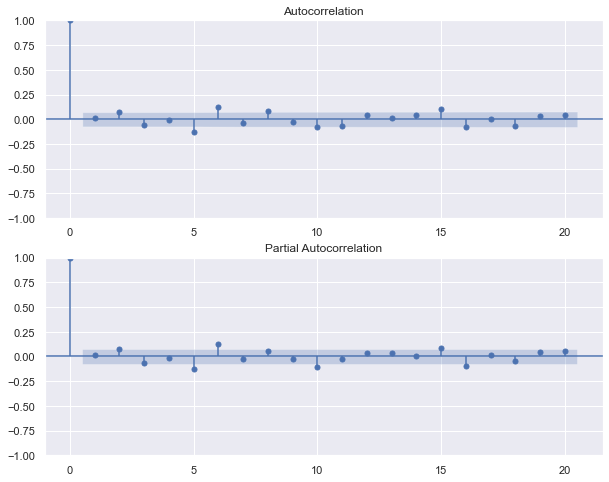

<Figure size 432x288 with 0 Axes>

In [109]:
plt.figure(figsize=(10, 8))
ax = plt.subplot(211)
plot_acf(df[df['Date'].dt.year == 2020]['ln_Close'], lags=20, ax=ax)
# plt.grid()
ax = plt.subplot(212)
plot_pacf(df[df['Date'].dt.year == 2020]['ln_Close'], lags=20, ax=ax, method='ywm')
# plt.grid()
plt.show()
plt.savefig('acf.jpeg')

# ARCH/GARCH

### 1/ Length of window

In [150]:
def plot_pnl_helper(cache_path, flag=False):
    with open(cache_path, 'rb') as f:
        data = pickle.load(f)
    data['Pred'] = np.sign(data['Pred'])
    data = data.iloc[:int(0.8 * data.shape[0]), :]
    if flag:
        plt.plot(data['Date'], data['Close'].diff().cumsum(), label='Buy&Hold', linestyle='--')
    plt.plot(data['Date'], data['Close'].diff().mul(data['Pred']).cumsum(), label=cache_path.replace('.pkl', '').replace('Strategy', ''), 
             linewidth=1.0)

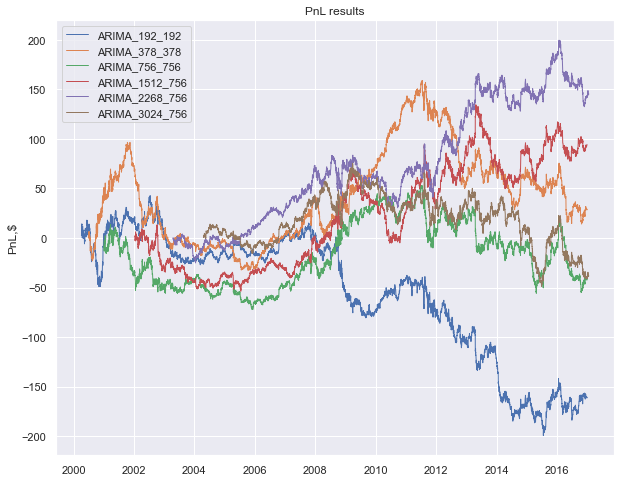

In [134]:
plt.figure(figsize=(10, 8))

plot_pnl_helper('StrategyARIMA_192_192.pkl')
plot_pnl_helper('StrategyARIMA_378_378.pkl')
plot_pnl_helper('StrategyARIMA_756_756.pkl')
plot_pnl_helper('StrategyARIMA_1512_756.pkl')
plot_pnl_helper('StrategyARIMA_2268_756.pkl')
plot_pnl_helper('StrategyARIMA_3024_756.pkl')


plt.ylabel('PnL,$')
plt.legend()
plt.title('PnL results')
plt.savefig('ARIMA_len.jpg')
plt.show()

### 2/ Refit frequency

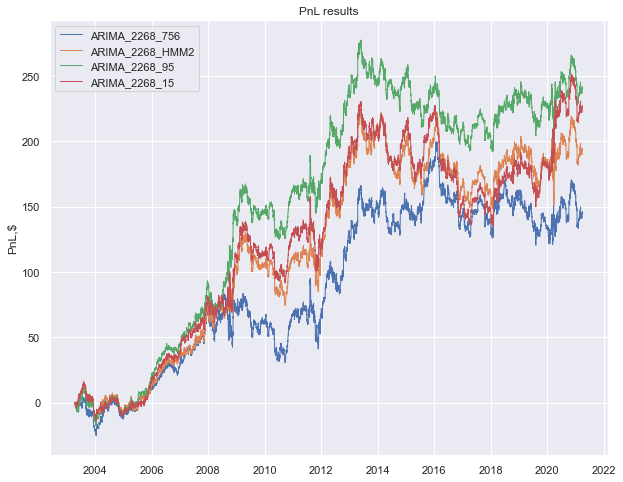

In [148]:
plt.figure(figsize=(10, 8))

plot_pnl_helper('StrategyARIMA_2268_756.pkl')
plot_pnl_helper('StrategyARIMA_2268_HMM2.pkl')
plot_pnl_helper('StrategyARIMA_2268_95.pkl')
plot_pnl_helper('StrategyARIMA_2268_15.pkl')

plt.ylabel('PnL,$')
plt.legend()
plt.title('PnL results')
plt.savefig('ARIMA_refit.jpg')
plt.show()

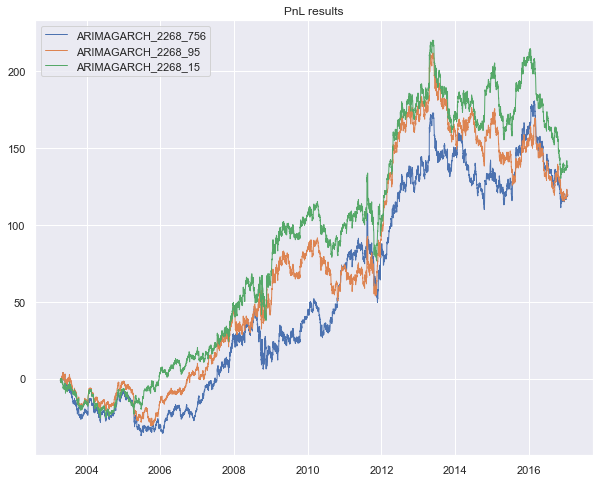

In [151]:
plt.figure(figsize=(10, 8))

plot_pnl_helper('StrategyARIMAGARCH_2268_756.pkl')
plot_pnl_helper('StrategyARIMAGARCH_2268_95.pkl')
# plot_pnl_helper('StrategyARIMAGARCH_1512_192.pkl')
# plot_pnl_helper('StrategyARIMAGARCH_1512_95.pkl')
plot_pnl_helper('StrategyARIMAGARCH_2268_15.pkl')


plt.legend()
plt.title('PnL results')
plt.show()

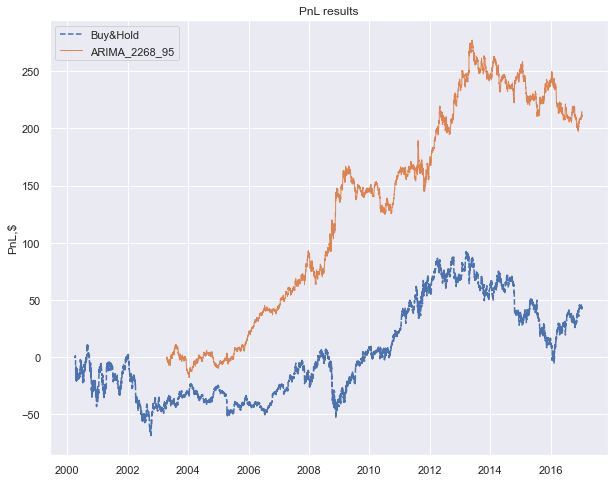

In [135]:
plt.figure(figsize=(10, 8))

plot_pnl_helper('StrategyARIMA_2268_95.pkl', True)


plt.ylabel('PnL,$')
plt.legend()
plt.title('PnL results')
plt.savefig('ARIMA_bench.jpg')
plt.show()

In [139]:
calculate_stats(['StrategyARIMA_2268_95.pkl'])

,StrategyARIMA_2268_95.pkl
Acc,0.51
F1,0.49
"ROI,%",189.89
Sharpe,0.51
"DD,%",-111.06


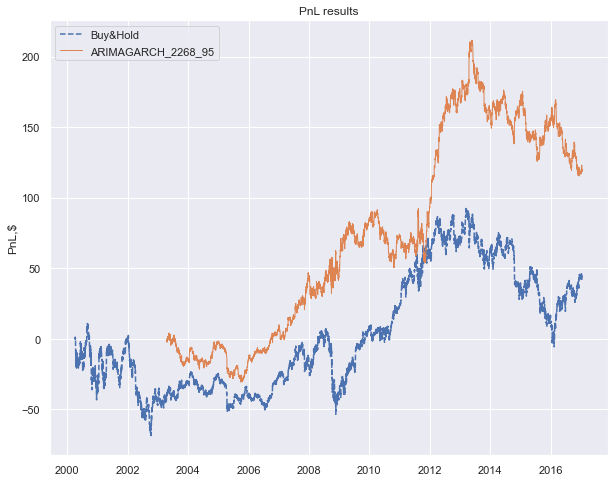

In [138]:
plt.figure(figsize=(10, 8))

plot_pnl_helper('StrategyARIMAGARCH_2268_95.pkl', True)


plt.ylabel('PnL,$')
plt.legend()
plt.title('PnL results')
plt.savefig('GARCH_bench.jpg')
plt.show()

In [141]:
calculate_stats(['StrategyARIMAGARCH_2268_95.pkl'])

,StrategyARIMAGARCH_2268_95.pkl
Acc,0.50
F1,0.53
"ROI,%",155.58
Sharpe,0.40
"DD,%",-66.70


In [103]:
def calculate_stats(cache_paths: list, s=3):
    df = {}
    for path in cache_paths:
        df[path] = []
        with open(path, 'rb') as f:
            data = pickle.load(f)
        df[path].append(
            round(accuracy_score(np.sign(data['target'].shift(1).iloc[data['Pred'].isna().sum():]), 
                                 np.sign(data['Pred'].iloc[data['Pred'].isna().sum():])), 2)
        )
        df[path].append(
            round(f1_score(np.sign(data['target'].shift(1).iloc[data['Pred'].isna().sum():]), 
                           np.sign(data['Pred'].iloc[data['Pred'].isna().sum():])), 2)
        )
        # ROI
        df[path].append(
            round((data['Close'].diff().mul(np.sign(data['Pred'])).cumsum().iloc[-1] / data['Close'].iloc[data['Pred'].isna().sum()] - 1)*100, 2)
        )
        # Sharpe ratio
        rets = data['Close'].pct_change().mul(np.sign(data['Pred']))
        rets.index = data['Date']
        df[path].append(
            round(np.mean(rets) / np.std(rets) * np.sqrt(252*s), 2)
        )
        # Drawdown
        df[path].append(
            round(rets.groupby([(rets.index.month),(rets.index.year)]).agg('sum').mul(np.sqrt(12)).min()*100, 2)
        )
    df = pd.DataFrame(df, index=[['Acc', 'F1', 'ROI,%', 'Sharpe', 'DD,%']])
    return df

In [27]:
with open('StrategyARIMAGARCH_2268_756.pkl', 'rb') as f:
    data = pickle.load(f)
    

In [46]:
round((data['Close'].diff().mul(np.sign(data['Pred'])).cumsum().iloc[-1] / data['Close'].iloc[data['Pred'].isna().sum()] - 1)*100, 2)

130.04

In [78]:
rets = data['Close'].pct_change().mul(np.sign(data['Pred']))
# round(np.mean(rets) / np.std(rets) * np.sqrt(252*3), 2)
rets.index = data['Date']

In [104]:
calculate_stats(['StrategyARIMAGARCH_2268_756.pkl'])

,StrategyARIMAGARCH_2268_756.pkl
Acc,0.50
F1,0.53
"ROI,%",130.04
Sharpe,0.34
"DD,%",-66.70


In [99]:
np.sign(data['ln_Close'].iloc[data['Pred'].isna().sum():]).value_counts()

13519

In [98]:
np.sign(data['Pred'].iloc[data['Pred'].isna().sum():]).value_counts().sum()

13519